In [1]:
import spacy

# In order to obtain the word vector, we need to load the large model
nlp = spacy.load('en_core_web_lg')

c:\Users\FURKANSALMAN\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
doc = nlp("dog cat banana kem")
for token in doc:
    print(token.text, "Vector:", token.has_vector, "OOV:", token.is_oov)

dog Vector: True OOV: False
cat Vector: True OOV: False
banana Vector: True OOV: False
kem Vector: False OOV: True


In [9]:
doc[0].vector.shape

(300,)

In [10]:
base_token = nlp("bread")
base_token.vector.shape

(300,)

As we have the word vectors, we can use them to compute the similarity between words.

In [11]:
doc = nlp("sandwich burger car tiger human wheat")

for token in doc:
    print(f"{token.text} <-> {base_token} : {token.similarity(base_token)}")

sandwich <-> bread : 0.6341067010130894
burger <-> bread : 0.47520687769584247
car <-> bread : 0.06451533308853552
tiger <-> bread : 0.04764611675903374
human <-> bread : 0.2151154210812192
wheat <-> bread : 0.6150360888607199


As we can see from the similarity scores above vector representation of words captures the context. The similarity score here actually assesses how likely two words would appear in the same context.

In [13]:
def print_similarity(base_word, words_to_compare):
    base_token = nlp(base_word)
    doc = nlp(words_to_compare)
    for token in doc:
        print(f"{token.text} <-> {base_token} : {token.similarity(base_token)}")


In [14]:
print_similarity("iphone", "apple samsung iphone dog kitten")

apple <-> iphone : 0.4387907401919904
samsung <-> iphone : 0.670859081425417
iphone <-> iphone : 1.000000072144752
dog <-> iphone : 0.08211864228011527
kitten <-> iphone : 0.10222317834969896


In [15]:
king = nlp.vocab['king'].vector
man = nlp.vocab['man'].vector
woman = nlp.vocab['woman'].vector
queen = nlp.vocab['queen'].vector

result = king - man + woman

In [16]:
# compare the result with queen
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([result], [queen])

array([[0.61780137]], dtype=float32)

# Text Classification using Spacy Word Vectors

In [1]:
import pandas as pd

df = pd.read_csv("Fake_Real_Data.csv")
df.head()

,Text,label
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake
1,U.S. conservative leader optimistic of common ...,Real
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real
3,Court Forces Ohio To Allow Millions Of Illega...,Fake
4,Democrats say Trump agrees to work on immigrat...,Real


In [2]:
df.shape

(9900, 2)

In [3]:
df.label.value_counts()

Fake    5000
Real    4900
Name: label, dtype: int64

In [4]:
df["num_label"] = df.label.map({"Fake": 1, "Real": 0})
df.head()

,Text,label,num_label
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake,1
1,U.S. conservative leader optimistic of common ...,Real,0
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real,0
3,Court Forces Ohio To Allow Millions Of Illega...,Fake,1
4,Democrats say Trump agrees to work on immigrat...,Real,0


In [6]:
import spacy

nlp = spacy.load('en_core_web_lg')

In [7]:
df["Vector"] = df["Text"].apply(lambda x: nlp(x).vector)
df.head()

,Text,label,num_label,Vector
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake,1,"[-0.6759837, 1.4263071, -2.318466, -0.451093, ..."
1,U.S. conservative leader optimistic of common ...,Real,0,"[-1.8355803, 1.3101058, -2.4919677, 1.0268308,..."
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real,0,"[-1.9851209, 0.14389805, -2.4221718, 0.9133005..."
3,Court Forces Ohio To Allow Millions Of Illega...,Fake,1,"[-2.7812982, -0.16120885, -1.609772, 1.3624227..."
4,Democrats say Trump agrees to work on immigrat...,Real,0,"[-2.2010763, 0.9961637, -2.4088492, 1.128273, ..."


In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df["Vector"].values, 
                                                    df["num_label"], 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=df["num_label"])

In [24]:
X_train.shape, X_test.shape

((7920,), (1980,))

In [25]:
y_train.value_counts()

1    4000
0    3920
Name: num_label, dtype: int64

In [26]:
y_test.value_counts()

1    1000
0     980
Name: num_label, dtype: int64

In [27]:
import numpy as np

X_train = np.stack(X_train) #converting nested array into 2-d array
X_test = np.stack(X_test)

In [28]:
X_train.shape, X_test.shape

((7920, 300), (1980, 300))

Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       980
           1       0.96      0.94      0.95      1000

    accuracy                           0.95      1980
   macro avg       0.95      0.95      0.95      1980
weighted avg       0.95      0.95      0.95      1980



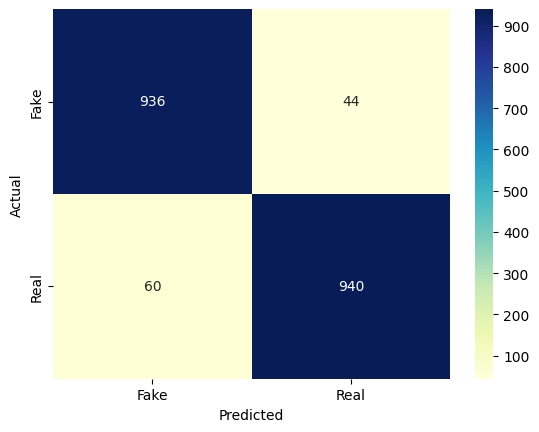

In [33]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from seaborn import heatmap
import matplotlib.pyplot as plt

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf = MultinomialNB()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Classification Report: \n", classification_report(y_test, y_pred))

# Confusion Matrix with labels
cm = confusion_matrix(y_test, y_pred)
heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1000

    accuracy                           0.99      1980
   macro avg       0.99      0.99      0.99      1980
weighted avg       0.99      0.99      0.99      1980



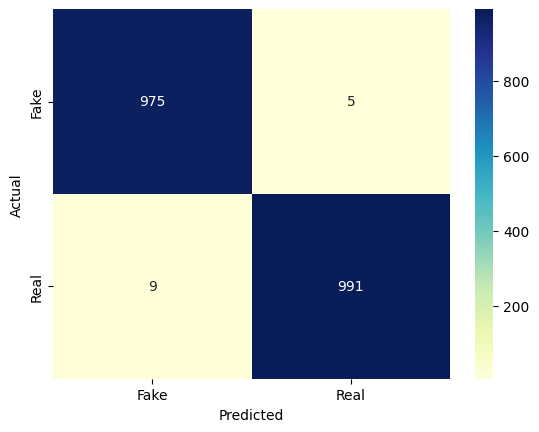

In [35]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=5, metric="euclidean")

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Classification Report: \n", classification_report(y_test, y_pred))

# Confusion Matrix with labels
cm = confusion_matrix(y_test, y_pred)
heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()